<a href="https://colab.research.google.com/github/Jaroken/ObjectDetection/blob/master/Colab_Object_Recognition_using_Google_Drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab Object Recognition with Google Drive Images

Colab is free and gives access to more compute power for deep learning than my out of data gaming PC. I decided it was well worth the effort to get familar with working entirely within the google environment. You will of course need to have a google account to run this example.

In this notebook I decided to adapt some code from an example Object Recognition in colab to work with files in google drive. I modified this notebook: https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb

In [3]:
#### Import Packages ####
# For measuring the inference time.
import time
import tempfile
import numpy as np
# For running inference on the TF-Hub module.
import tensorflow as tf
import tensorflow_hub as hub
# For image handling
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import matplotlib.pyplot as plt
# For connecting to google drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

     |████████████████████████████████| 993kB 35.4MB/s 


In [4]:
# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


Here I have some of the helper function's that came with the tutorial I adapted

In [0]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image


def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In order to access google drive I used the following code to authenticate a connection between colab and drive. You will need to click on the link provided after running the code and get the key provided.

In [0]:
# Enter authentification to access google drive files
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

You can right click on the image you want to bring in and then click share.
![alt text](https://cdn.guidingtech.com/imager/media/assets/Google-Drive-1_74c3a965ea126a2dd446729d04c12124.jpg)

Then in the link provided for sharing you can grab the id from the url:
https://drive.google.com/file/d/1mg8_ZVT5p4-d5xP_CdJy9Rp5Bn9cRvM_/view?usp=sharing

You will only need the code from after file/d/ and before /view?. In this case it is 1mg8_ZVT5p4-d5xP_CdJy9Rp5Bn9cRvM_. This is the id we will use to pull in the picture I want from my google drive.

In [0]:
# id provided in the google drive share link
id = '0BzKMiXPbhZ6qZVlnU0NOd0F3enc4MnRhb3VUN1M1NVMtTDNZ'

### Edit Download function to grab from Google Drive
Here I edited the download_and_resize_image function to work with google drive instead of from publicly available images on the net. The original tutorial includes this functionality. 

In [0]:
def download_and_resize_image(id, new_width=256, new_height=256, display=False):
  # Here I edited a the function to grab the file from google drive
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('Filename.jpg')
  _, filename = tempfile.mkstemp(suffix=".jpg")
  pil_image = Image.open('Filename.jpg')
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return(filename)


### Run the the edited function

In [0]:
downloaded_image_path = download_and_resize_image(id, 1280, 856)

### Run image recognition

Found 100 objects.


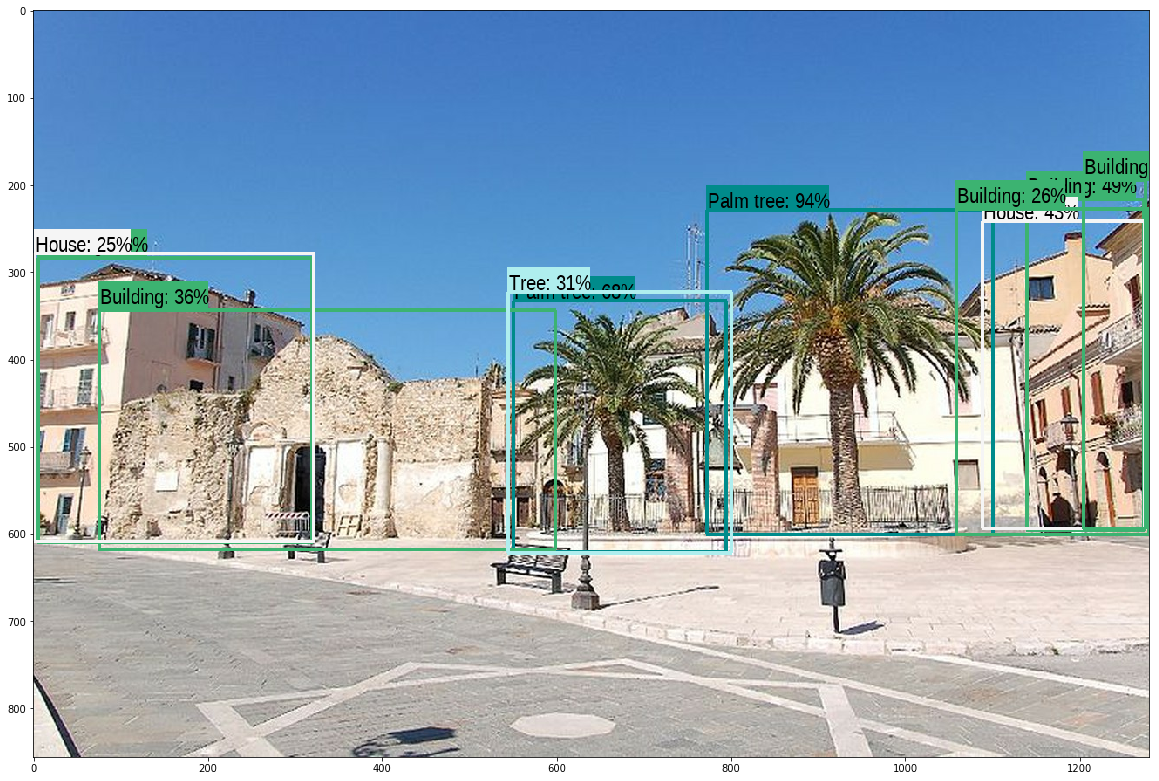

In [10]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

with tf.Graph().as_default():
  detector = hub.Module(module_handle)
  image_string_placeholder = tf.placeholder(tf.string)
  decoded_image = tf.image.decode_jpeg(image_string_placeholder)
  # Module accepts as input tensors of shape [1, height, width, 3], i.e. batch
  # of size 1 and type tf.float32.
  decoded_image_float = tf.image.convert_image_dtype(
      image=decoded_image, dtype=tf.float32)
  module_input = tf.expand_dims(decoded_image_float, 0)
  result = detector(module_input, as_dict=True)
  init_ops = [tf.global_variables_initializer(), tf.tables_initializer()]

  session = tf.Session()
  session.run(init_ops)

  # Load the downloaded and resized image and feed into the graph.
  with tf.gfile.Open(downloaded_image_path, "rb") as binfile:
    image_string = binfile.read()

  result_out, image_out = session.run(
      [result, decoded_image],
      feed_dict={image_string_placeholder: image_string})
  print("Found %d objects." % len(result_out["detection_scores"]))

image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"])

display_image(image_with_boxes)

### Try running additional files
I put a random image into my google drive and tried running object detection for an additional random photo.

Image downloaded to /tmp/tmp4k8xy3qi.jpg.
Found 100 objects.
Inference took 3.40 seconds.


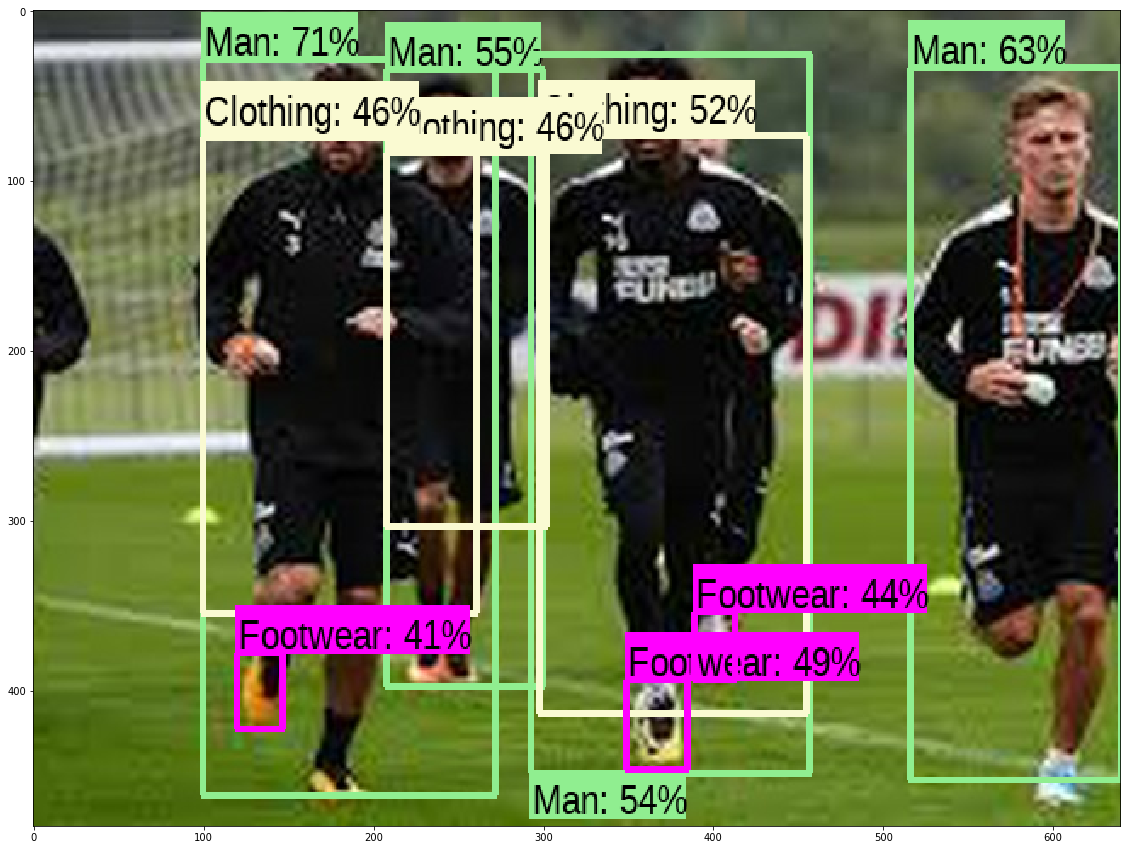

In [11]:
image_urls = ["1mg8_ZVT5p4-d5xP_CdJy9Rp5Bn9cRvM_"]

for image_url in image_urls:
  image_path = download_and_resize_image(image_url, 640, 480)
  with tf.gfile.Open(image_path, "rb") as binfile:
    image_string = binfile.read()

  inference_start_time = time.clock()
  result_out, image_out = session.run(
      [result, decoded_image],
      feed_dict={image_string_placeholder: image_string})
  print("Found %d objects." % len(result_out["detection_scores"]))
  print("Inference took %.2f seconds." % (time.clock()-inference_start_time))

  image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"])

  display_image(image_with_boxes)

### Conclusion

Doing object detection on colab is pretty easy, and now I can use google drive images for future work in colab. The next few project I want to explore in colab are training for custom object detection, running yolo video object detection, and then train for custom video object detection. 


### Author Contact
If you would like to reach out to me the best place to communicate with me is on linkedin:
www.linkedin.com/in/kennethjpreston